# CNN Bonus Assignment

In [1]:
import numpy as np
from keras.datasets import mnist 
import matplotlib.pyplot as plt
from PIL import Image

2024-05-15 23:20:19.255336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# loading the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Note: Due to the computationally heavy operations of cnn reducing the dataset size to complete the assignment
train_images = train_images[:5000] / 255.0  # using 5000 images for training
train_labels = train_labels[:5000]
test_images = test_images[:2000] / 255.0  # using 2000 images for testing
test_labels = test_labels[:2000]

In [3]:
train_images[0].size

784

### CNN Architecture
1. Input Layer: 28x28 grayscale image
2. First CNN Layer: 2 neurons with kernel size 3x3, stride 1, and Sigmoid activation
3. Average Pooling Layer with pool size 2x2 and stride 2
4. Flatten the output from the average pooling layer
5. 1x1 Convolution Layer with 10 output channels
6. Softmax Activation

In [4]:
class CNN:
    def __init__(self):
        # initializing the weights and biases for the convolutional layers
        # conv1_weights: 2 filters of size 3x3
        # conv2_weights: 10 filters for the fully connected layer
        self.conv1_weights = np.random.randn(2, 3, 3) * 0.01  
        self.conv1_bias = np.zeros(2)
        self.conv2_weights = np.random.randn(10, 338) * 0.01  
        self.conv2_bias = np.zeros(10)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum()

    def convolve(self, image, kernel, bias, stride=1):
        # convolution operation on the input image
        kernel_height, kernel_width = kernel.shape
        output_height = (image.shape[0] - kernel_height) // stride + 1
        output_width = (image.shape[1] - kernel_width) // stride + 1
        output = np.zeros((output_height, output_width))
        
        for i in range(output_height):
            for j in range(output_width):
                output[i, j] = np.sum(image[i*stride:i*stride+kernel_height, j*stride:j*stride+kernel_width] * kernel) + bias
                
        return output

    def average_pooling(self, image, pool_size=2, stride=2):
        # average pooling operation
        output_height = (image.shape[0] - pool_size) // stride + 1
        output_width = (image.shape[1] - pool_size) // stride + 1
        output = np.zeros((output_height, output_width))
        
        for i in range(output_height):
            for j in range(output_width):
                output[i, j] = np.mean(image[i*stride:i*stride+pool_size, j*stride:j*stride+pool_size])
                
        return output

    def forward(self, x):
        # forward pass through the network
        # first convolutional layer with sigmoid activation
        self.conv1_output = np.zeros((2, x.shape[0] - 2, x.shape[1] - 2))
        for i in range(2):
            self.conv1_output[i] = self.sigmoid(self.convolve(x, self.conv1_weights[i], self.conv1_bias[i]))
        
        # average pooling layer
        self.pool_output = np.zeros((2, (self.conv1_output.shape[1] - 1) // 2 + 1, (self.conv1_output.shape[2] - 1) // 2 + 1))
        for i in range(2):
            self.pool_output[i] = self.average_pooling(self.conv1_output[i])

        # flatten the pooled output
        self.flatten_output = self.pool_output.flatten()
        
        # fully connected layer with softmax activation
        self.conv2_output = self.softmax(np.dot(self.conv2_weights, self.flatten_output) + self.conv2_bias)
        
        return self.conv2_output

    def backward(self, x, y, learning_rate=0.01):
        # first getting the error 
        error = self.conv2_output - y
        
        # gradients for the fully connected layer
        dconv2_weights = np.outer(error, self.flatten_output)
        dconv2_bias = error
        
        # propagating gradients through the pooling layer
        dpool_output = np.dot(self.conv2_weights.T, error).reshape(self.pool_output.shape)
        
        # propagating gradients through convolutional layer
        dconv1_output = np.zeros_like(self.conv1_output)
        for i in range(2):
            dconv1_output[i] = self.sigmoid_derivative(self.conv1_output[i]) * np.kron(dpool_output[i], np.ones((2, 2)) / 4)
        
        # gradients for the first convolutional layer
        dconv1_weights = np.zeros_like(self.conv1_weights)
        dconv1_bias = np.zeros_like(self.conv1_bias)
        for i in range(2):
            for j in range(dconv1_output.shape[1]):
                for k in range(dconv1_output.shape[2]):
                    dconv1_weights[i] += x[j:j+3, k:k+3] * dconv1_output[i, j, k]
                    dconv1_bias[i] += dconv1_output[i, j, k]
        
        # updating weights and biases
        self.conv2_weights -= learning_rate * dconv2_weights
        self.conv2_bias -= learning_rate * dconv2_bias
        self.conv1_weights -= learning_rate * dconv1_weights
        self.conv1_bias -= learning_rate * dconv1_bias

    def train(self, train_images, train_labels, test_images, test_labels, epochs=10, learning_rate=0.01, batch_size=32):
        # training loop for the network
        print("Training the model...")
        num_batches = len(train_images) // batch_size
        loss_per_epoch = []
        test_loss_per_epoch = []
        for epoch in range(epochs):
            epoch_loss = 0
            for batch in range(num_batches):
                batch_start = batch * batch_size
                batch_end = batch_start + batch_size
                batch_images = train_images[batch_start:batch_end]
                batch_labels = train_labels[batch_start:batch_end]
                
                for i in range(batch_size):
                    x = batch_images[i]
                    y = np.zeros(10)
                    y[batch_labels[i]] = 1
                    output = self.forward(x)
                    epoch_loss += -np.sum(y * np.log(output))
                    self.backward(x, y, learning_rate)
                    
            loss_per_epoch.append(epoch_loss / len(train_images))
            print(f"Epoch {epoch+1}/{epochs} complete, Loss: {loss_per_epoch[-1]:.4f}")
            
            _, test_loss = self.evaluate(test_images, test_labels)
            test_loss_per_epoch.append(test_loss)
        
        return loss_per_epoch, test_loss_per_epoch

    def evaluate(self, test_images, test_labels):
        # evaluating the network on the test set
        correct = 0
        test_loss = 0
        for i in range(len(test_images)):
            x = test_images[i]
            y = np.zeros(10)
            y[test_labels[i]] = 1
            output = self.forward(x)
            test_loss += -np.sum(y * np.log(output))
            prediction = np.argmax(output)
            if prediction == test_labels[i]:
                correct += 1
        accuracy = correct / len(test_images)
        test_loss /= len(test_images)
        return accuracy, test_loss


In [5]:
cnn = CNN()
training_losses, test_losses = cnn.train(train_images, train_labels, test_images, test_labels, epochs=10, learning_rate=0.01, batch_size=32)
accuracy, test_loss = cnn.evaluate(test_images, test_labels)

print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

Training the model...
Epoch 1/10 complete, Loss: 1.2973
Epoch 2/10 complete, Loss: 0.4711
Epoch 3/10 complete, Loss: 0.4016
Epoch 4/10 complete, Loss: 0.3709
Epoch 5/10 complete, Loss: 0.3517
Epoch 6/10 complete, Loss: 0.3379
Epoch 7/10 complete, Loss: 0.3271
Epoch 8/10 complete, Loss: 0.3182
Epoch 9/10 complete, Loss: 0.3107
Epoch 10/10 complete, Loss: 0.3043
Final Test Accuracy: 0.8700
Final Test Loss: 0.4249


### CNN Report

The CNN class defines a simple convolutional neural network designed to perform image classification tasks. The network's architecture is as follows:

1. **Initialization**: The first convolutional layer (conv1_weights) has two filters of size 3x3, while the second layer (conv2_weights) acts as a fully connected layer with 10 output neurons, corresponding to the number of classes in the classification task. The weights are initialized with small random values to allow some variance at start and the biases are initialized to zero.

2. **Activation Functions**: The network uses the sigmoid activation function for the first convolutional layer, implemented in the sigmoid method. The derivative of the sigmoid function, used during backpropagation, is defined in the sigmoid_derivative method. The output layer uses the softmax function, implemented in the softmax method, to produce class probabilities.

3. **Convolution Operation**: The convolve method performs the convolution operation on the input image. It takes the input image, a kernel (filter), and a bias term, and slides the kernel over the image to compute the output feature map. 

4. **Pooling Operation**: The average_pooling method performs average pooling on the input feature map. This operation reduces the spatial dimensions of the feature map by taking the average of non-overlapping regions of a specified size (2x2 by default) and stride.

5. **Forward Pass**: The forward method processes the input image through the network. First, it applies the convolution operation using the first set of filters, followed by the sigmoid activation function. Then, it applies average pooling to the resulting feature maps. The pooled output is flattened into a one-dimensional array and passed through the fully connected layer, which uses the softmax function to produce the final class probabilities.

6. **Backward Pass**: The backward method performs backpropagation to update the network's weights and biases. It calculates the error between the predicted and actual output and propagates this error backward through the network. Gradients for the fully connected layer are computed first, followed by the gradients for the pooling and convolutional layers. The weights and biases are updated using these gradients and a specified learning rate.

The training process involves iterating over the training data for a specified number of epochs, updating the network's parameters to minimize the loss. The evaluation process provides metrics to check the network's performance.

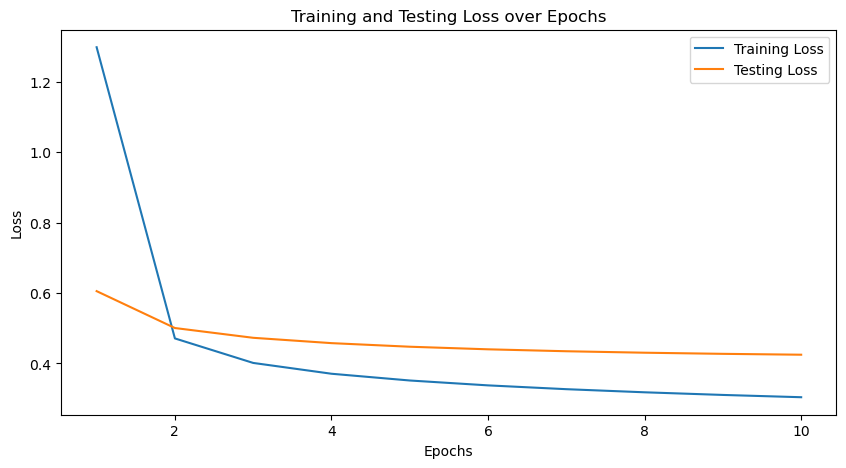

In [6]:
epochs = np.arange(1, len(training_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Testing Loss')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Training and Evaluation Results
The CNN model was trained for 10 epochs on the given dataset. The final test accuracy achieved by the model was 86.90%, with a final test loss of 0.4250. The above graph shows the gradual decrease in the training and the testing losses, implying that the model is able to make good inference of thr image given to it.